## Preparación del dataset

Importamos 4 dataset distintos de reviews de amazon, eliminamos todas aquellas reviews con valores nulos, seleccionamos 10000 muestras de cada dataset y los unimos.

In [1]:
import pandas as pd

df_automotive = pd.read_json('../../data_practica/Automotive_5.json', lines=True)
df_music = pd.read_json('../../data_practica/Musical_Instruments_5.json', lines=True)
df_office = pd.read_json('../../data_practica/Office_Products_5.json', lines=True)
df_garden = pd.read_json('../../data_practica/Patio_Lawn_and_Garden_5.json', lines=True)

In [2]:
lista = [df_automotive, df_music, df_office, df_garden]
for i in lista:
    print(len(i))

20473
10261
53258
13272


In [3]:
df_automotive.dropna(subset=['reviewText'], inplace=True)
df_music.dropna(subset=['reviewText'], inplace=True)
df_office.dropna(subset=['reviewText'], inplace=True)
df_garden.dropna(subset=['reviewText'], inplace=True)

Como se puede comproar, no se ha eliminado ningun dato.

In [4]:
lista = [df_automotive, df_music, df_office, df_garden]
for i in lista:
    print(len(i))

20473
10261
53258
13272


In [5]:
df_automotive = pd.DataFrame(df_automotive).sample(n=10000)
df_music = pd.DataFrame(df_music).sample(n=10000)
df_office = pd.DataFrame(df_office).sample(n=10000)
df_garden = pd.DataFrame(df_garden).sample(n=10000)

In [6]:
df_entero = pd.concat([df_automotive, df_music, df_office, df_garden], axis=0)

In [7]:
len(df_entero)

40000

Hacemos un shuffle para mezclar los datos de manera aleatoria, para no cometer ninguna infracción en el modelo.

In [8]:
from sklearn.utils import shuffle
df_entero = shuffle(df_entero)

In [9]:
lista = [df_automotive, df_music, df_office, df_garden]
for i in lista:
    print(len(i))

10000
10000
10000
10000


## Topic Modeling

Seleccionamos unicamente la columna de reviews para realizar el topic modeling.

In [10]:
df_final = pd.DataFrame(df_entero, columns = ['reviewText'])

In [11]:
df_final.head()

,reviewText
41189,Besides the benefit of having twice the erasin...
44500,"These pens are great. Smooth writing, and I r..."
37849,"I've had Epson and HP printers, and both have ..."
12647,love this mount. works great and looks good to...
9831,It is okay. It serves the purpose. It is a goo...


Hacemos una primera aproximacion con el procesado de gensim, sin realizar un preprocesado mayor.

In [12]:
!pip install gensim
# !pip install pyLDAvis

In [13]:
import random
import pandas as pd

import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel, CoherenceModel

import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt

C:\Users\LBastos\Anaconda3\lib\site-packages\past\types\oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
C:\Users\LBastos\Anaconda3\lib\site-packages\past\builtins\misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping


In [14]:
def text_preprocessing(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

In [15]:
processed_texts_gensim = []
for text in df_final['reviewText']:
    processed_texts_gensim.append(text_preprocessing(text))

In [17]:
dictionary_newsgroup = Dictionary(processed_texts_gensim)
corpus_newsgroup = [dictionary_newsgroup.doc2bow(doc) for doc in processed_texts_gensim]

Lanzamos un LDA con un num de tpoic igual al de dataset, porque deberia poder clasificar como minimo estos 4.

In [18]:
num_topics = 4

lda_model_newsgroup = LdaModel(
    corpus=corpus_newsgroup,
    id2word=dictionary_newsgroup,
    num_topics=num_topics,
    passes=10
)

In [19]:
word_dict = {};
for i in range(num_topics):
    words = lda_model_newsgroup.show_topic(i, topn = 15)
    word_dict['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict)

,Topic #01,Topic #02,Topic #03,Topic #04
0,like,water,like,printer
1,great,product,great,paper
2,feeder,like,good,like
3,sound,battery,guitar,tape
4,good,trap,nice,print
5,strings,time,easy,time
6,pedal,hose,little,great
7,clean,easy,quality,easy
8,product,work,price,good
9,guitar,little,works,quality


Se puede comprobar que no se hace una clasificación clara.

Por ejemplo, en el topic uno podriamos decir que pertenece al datset de oficina, pues hay palabras como impresora, papel, calidad, product, price.... Pero tambien hay palabras de este tema como por ejemplo raton presente en otros topics.
En el topic 2, hay bastante palabras que nos pueden decir que pertenece al dataset de musica 
El topic 3, no esta muy claro.
El topic 4 tiene varias palabras que hacen referencia a tema de automotive.

Vemos que hari varios topics que se pueden asemejar a nuestros dataset, salvo el de garden que tiene palabras qen varios topics.

Vamos a realizar un preoprocesado del texto mayor. 

In [20]:
def text_normalizer(text, lemmatize=False, sw_list=None):
    
    processed_text = []
    
    if sw_list is None:
        sw_list = []
    
    if lemmatize:
        lemmas_dict = get_lemmas_dict(data_path, lemmas_dict_file)
    
    # Convierte el texto a minúsuculas, y eliminamos espacios
    text = text.lower().strip()
    
    # Eliminar caracteres "extraños"
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # Tabla para eliminar signos de puntuación
    table = str.maketrans('', '', string.punctuation)
    
    # Segmentar texto en frases
    sentences = text.split('.')
    
    # Para cada frase
    for sentence in sentences:
        sentence = ' '.join(sentence.split())
        words = sentence.split(' ')
        # Para cada palabra
        for word in words:
            if word not in string.punctuation and word not in sw_list:  # Si se pasa, elimina stop words
                word = word.translate(table)
                if lemmatize:
                    word = lemmas_dict.get(word, word)
                if word.isdigit():
                    word = num2words(word, lang='es')
            processed_text.append(word)
    
        
    
    return ' '.join(processed_text)

In [21]:
import unicodedata

import string

from num2words import num2words



In [22]:
processed_texts_pipeline = []
for text in df_final['reviewText']:
    processed_texts_pipeline.append(text_normalizer(text))

In [23]:
result = []
for sentence in processed_texts_pipeline:
    list_aux = []
    for word in sentence.split():
        list_aux.append(word)
    result.append(list_aux)

In [24]:
#Necesitamos un diccionario con un numero asociado a cada palabra
dictionary = Dictionary(result)

In [25]:
dictionary2 = Dictionary(result)
corpus2 = [dictionary2.doc2bow(doc) for doc in result]

In [26]:
num_topics2 = 4

lda_model2 = LdaModel(
    corpus=corpus2,
    id2word=dictionary2,
    num_topics=num_topics2,
    iterations=5,
    passes=10,
    alpha='auto'
)

In [27]:
lda_model2.show_topics()

[(0,
  '0.055*"the" + 0.031*"to" + 0.024*"a" + 0.023*"and" + 0.019*"is" + 0.017*"of" + 0.014*"i" + 0.014*"for" + 0.013*"you" + 0.012*"that"'),
 (1,
  '0.059*"the" + 0.034*"to" + 0.028*"and" + 0.027*"i" + 0.025*"it" + 0.022*"a" + 0.018*"of" + 0.016*"in" + 0.014*"this" + 0.011*"have"'),
 (2,
  '0.053*"i" + 0.035*"and" + 0.028*"a" + 0.020*"the" + 0.020*"for" + 0.019*"my" + 0.018*"to" + 0.014*"they" + 0.014*"these" + 0.013*"it"'),
 (3,
  '0.078*"the" + 0.035*"it" + 0.032*"a" + 0.030*"to" + 0.030*"is" + 0.025*"and" + 0.017*"of" + 0.017*"this" + 0.015*"you" + 0.013*"on"')]

In [28]:
word_dict2 = {};
for i in range(num_topics2):
    words = lda_model2.show_topic(i, topn = 15)
    word_dict2['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict2)

,Topic #01,Topic #02,Topic #03,Topic #04
0,the,the,i,the
1,to,to,and,it
2,a,and,a,a
3,and,i,the,to
4,is,it,for,is
5,of,a,my,and
6,i,of,to,of
7,for,in,they,this
8,you,this,these,you
9,that,have,it,on


Aqui vemos claramente que al no eliminar ninguna stop word, el dataset nos nos clasifica nada.

Vamos a hacer lo mismo, pero eliminadno aquellas palabras con longitud menor de 3, para ver si podemos sacar algo en claro.

In [291]:
#Eliminamos las palabras con length menor de 3

In [29]:
result_len3 = []
for sentence in processed_texts_pipeline:
    list_aux = []
    for word in sentence.split():
        if len(word) > 3:
            list_aux.append(word)
    result_len3.append(list_aux)

In [30]:
len(result_len3)

40000

In [31]:
dictionary3 = Dictionary(result_len3)

In [32]:
corpus3 = [dictionary3.doc2bow(doc) for doc in result_len3]

In [33]:
num_topics = 4

lda_model3 = LdaModel(
    corpus=corpus3,
    id2word=dictionary3,
    num_topics=num_topics,
    iterations=5,
    passes=10,
    alpha='auto'
)

In [34]:
lda_model3.show_topics()

[(0,
  '0.022*"that" + 0.019*"they" + 0.017*"these" + 0.015*"this" + 0.014*"with" + 0.013*"them" + 0.012*"have" + 0.009*"like" + 0.008*"very" + 0.006*"would"'),
 (1,
  '0.031*"this" + 0.018*"with" + 0.015*"that" + 0.013*"have" + 0.012*"great" + 0.011*"good" + 0.009*"very" + 0.009*"just" + 0.008*"like" + 0.008*"well"'),
 (2,
  '0.026*"this" + 0.018*"that" + 0.017*"have" + 0.014*"with" + 0.008*"will" + 0.006*"water" + 0.006*"when" + 0.006*"from" + 0.006*"product" + 0.005*"after"'),
 (3,
  '0.020*"this" + 0.020*"that" + 0.017*"with" + 0.012*"have" + 0.011*"printer" + 0.008*"from" + 0.005*"print" + 0.005*"which" + 0.005*"your" + 0.005*"paper"')]

In [35]:
word_dict3 = {};
for i in range(num_topics2):
    words = lda_model3.show_topic(i, topn = 15)
    word_dict3['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict3)

,Topic #01,Topic #02,Topic #03,Topic #04
0,that,this,this,this
1,they,with,that,that
2,these,that,have,with
3,this,have,with,have
4,with,great,will,printer
5,them,good,water,from
6,have,very,when,print
7,like,just,from,which
8,very,like,product,your
9,would,well,after,paper


Vemos que hemos mejorado algo el modelo, pero aun nos esta poniendo palabras que no nos aportan nada. Por lo que, vamos a crear una lista de stop words con aquellas palabras que mas se repiten en el dataset.

In [73]:
from collections import Counter

words = []
for sentence in processed_texts_pipeline:
    for word in sentence.split():
        words.append(word)

counter_obj = Counter(words)

stop_words_count = counter_obj.most_common(n=60)

In [74]:
words = [w[0] for w in stop_words_count]
freqs = [w[1] for w in stop_words_count]

In [75]:
freqs, words = zip(*sorted(zip(freqs, words)))

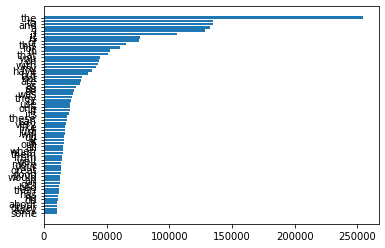

In [76]:
plt.barh(words, freqs)
plt.show()

In [77]:
words

('some',
 'easy',
 'other',
 'about',
 'do',
 'no',
 'has',
 'than',
 'had',
 'get',
 'an',
 'would',
 'good',
 'great',
 'your',
 'more',
 'well',
 'from',
 'them',
 'when',
 'all',
 'out',
 'at',
 'up',
 'will',
 'just',
 'like',
 'very',
 'can',
 'these',
 'its',
 'if',
 'one',
 'use',
 'or',
 'they',
 'was',
 'be',
 'so',
 'as',
 'are',
 'not',
 'but',
 'have',
 'my',
 'with',
 'on',
 'you',
 'that',
 'in',
 'for',
 'this',
 'of',
 'is',
 'it',
 'i',
 'a',
 'and',
 'to',
 'the')

He probado con la visualizacion desde n = 10, hasta 50 y aunque lo ideal seria ir poco a poco voy a quitar las 50  

In [79]:
result_stop = []
for sentence in processed_texts_pipeline:
    list_aux = []
    for word in sentence.split():
        if word not in words:
            if len(word) > 3 not in words:
                list_aux.append(word)
    result_stop.append(list_aux)

In [80]:
dictionary4 = Dictionary(result_stop)

In [81]:
corpus4 = [dictionary4.doc2bow(doc) for doc in result_stop]

In [82]:
num_topics4 = 4

lda_model4 = LdaModel(
    corpus=corpus4,
    id2word=dictionary4,
    num_topics=num_topics4,
    iterations=5,
    passes=10,
    alpha='auto'
)

In [83]:
lda_model4.show_topics()

[(0,
  '0.008*"product" + 0.007*"water" + 0.007*"feeder" + 0.006*"after" + 0.006*"trap" + 0.006*"used" + 0.005*"time" + 0.005*"hose" + 0.005*"there" + 0.005*"dont"'),
 (1,
  '0.006*"nice" + 0.006*"tape" + 0.005*"also" + 0.005*"paper" + 0.005*"product" + 0.005*"easily" + 0.005*"which" + 0.005*"hold" + 0.005*"really" + 0.005*"size"'),
 (2,
  '0.012*"printer" + 0.007*"battery" + 0.006*"unit" + 0.006*"print" + 0.006*"power" + 0.005*"cinco" + 0.005*"time" + 0.005*"which" + 0.005*"only" + 0.004*"also"'),
 (3,
  '0.009*"guitar" + 0.008*"price" + 0.006*"sound" + 0.006*"bought" + 0.006*"works" + 0.006*"really" + 0.006*"what" + 0.006*"much" + 0.006*"strings" + 0.006*"quality"')]

In [84]:
word_dict4 = {};
for i in range(num_topics4):
    words = lda_model4.show_topic(i, topn = 15)
    word_dict4['Topic #' + '{:02d}'.format(i+1)] = [i[0] for i in words]
pd.DataFrame(word_dict4)

,Topic #01,Topic #02,Topic #03,Topic #04
0,product,nice,printer,guitar
1,water,tape,battery,price
2,feeder,also,unit,sound
3,after,paper,print,bought
4,trap,product,power,works
5,used,easily,cinco,really
6,time,which,time,what
7,hose,hold,which,much
8,there,really,only,strings
9,dont,size,also,quality


Vemos que el modelo ha mejorado algo respecto a los anteriores, pero no mucho respecto del primero. Podemos ver que hay diferencis entre topics, pero hay algunas palabras que se repiten entre ellos.

Podríamos añadir más palabras a la lista de stop words o lemmatizar, tambien aumentar el numero de topics a ver si nos puede encontrar alguna relación. Pero, lo que haria yo serñia aumentar la lista de stop words.

In [87]:
# from sklearn.feature_extraction.text import CountVectorizer
from nltk import ngrams
from nltk.probability import FreqDist

C:\Users\LBastos\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\Users\LBastos\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict


In [91]:
result_stop = []
for sentence in processed_texts_pipeline:
    for word in sentence.split():
        if word not in words:
            if len(word) > 3 not in words:
                result_stop.append(word)


In [92]:
bigrams_ = list(ngrams(result_stop, 2))
trigrams_ = list(ngrams(result_stop, 3))

In [94]:
bg_freq = FreqDist(bigrams_)
tg_freq = FreqDist(trigrams_)

In [95]:
bg_freq_most_common = bg_freq.most_common(10)
bgs_ = [str(bg[0]) for bg in bg_freq_most_common]
bgs_f_ = [bg[1] for bg in bg_freq_most_common]

tg_freq_most_common = tg_freq.most_common(10)
tgs_ = [str(tg[0]) for tg in tg_freq_most_common]
tgs_f_ = [tg[1] for tg in tg_freq_most_common]

In [96]:
bgs_f_, bgs_ = zip(*sorted(zip(bgs_f_, bgs_)))
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))

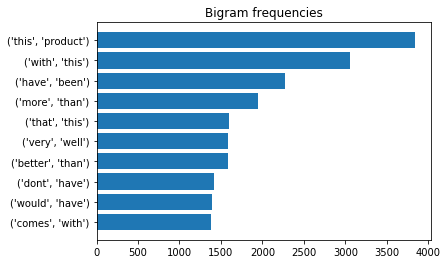

In [97]:
plt.barh(bgs_, bgs_f_)
plt.title('Bigram frequencies')
plt.show()

Podemos ver, que esos bigramas no nos afectaría mucho, por lo que tambien habría que añadirlos a la lista de stop words.

No he querido seguir para no quedarme sin tiempo, he intentado empezar desde algo muy basico e ir construyendo hacia mas especifico.

No he querido utilizar una lista de stop_words hecha (aunque en la de gensim si, para ver la diferencia),porque me parece más interesante que sea el programador el que analizando cada modelo decida que palabras eliminar, puesto que cada dataset o cada modelo es diferente.

## Análisis de sentimiento

In [98]:
df_entero.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
41189,A2JXCOUGYS5Y4J,B007TRUWG4,anonymous,"[0, 0]",Besides the benefit of having twice the erasin...,5,"Comfortable to hold, extrudes well, affordable...",1350518400,"10 18, 2012"
44500,A2QR043WBXXX6L,B009QYH40U,Stephen Cunningham,"[0, 1]","These pens are great. Smooth writing, and I r...",5,Heads up Quilters!,1361923200,"02 27, 2013"
37849,A1RPJHUVVSI98A,B005HFJFKE,Justin Opinion,"[5, 5]","I've had Epson and HP printers, and both have ...",5,Excellent quality and functionality at a good ...,1329609600,"02 19, 2012"
12647,AUS4IZFUU78TK,B0022ZF2ZO,Moe,"[0, 0]",love this mount. works great and looks good to...,5,mount,1372118400,"06 25, 2013"
9831,AJZWAEYCF43WH,B008GS3XLQ,Norm,"[0, 0]",It is okay. It serves the purpose. It is a goo...,3,Serves the purpose.,1389916800,"01 17, 2014"


In [99]:
df_entero['overall'].describe()

count    40000.000000
mean         4.371100
std          0.973195
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: overall, dtype: float64

In [110]:

df = pd.DataFrame(df_entero, columns = ['reviewText', 'overall'])


In [111]:
df.head()

,reviewText,overall
41189,Besides the benefit of having twice the erasin...,5
44500,"These pens are great. Smooth writing, and I r...",5
37849,"I've had Epson and HP printers, and both have ...",5
12647,love this mount. works great and looks good to...,5
9831,It is okay. It serves the purpose. It is a goo...,3


In [112]:
def label_sentiment(row):
    if int(row['overall']) < 3:
        return 'neg'
    else:
        return 'pos'

In [113]:
df['sentiment_label'] = df.apply(lambda row: label_sentiment(row), axis=1)

In [114]:
df.head()

,reviewText,overall,sentiment_label
41189,Besides the benefit of having twice the erasin...,5,pos
44500,"These pens are great. Smooth writing, and I r...",5,pos
37849,"I've had Epson and HP printers, and both have ...",5,pos
12647,love this mount. works great and looks good to...,5,pos
9831,It is okay. It serves the purpose. It is a goo...,3,pos


df.columns = ['review', 'sentiment', 'sentiment_label' ]

In [118]:
df.head()

,review,sentiment,sentiment_label
41189,Besides the benefit of having twice the erasin...,5,pos
44500,"These pens are great. Smooth writing, and I r...",5,pos
37849,"I've had Epson and HP printers, and both have ...",5,pos
12647,love this mount. works great and looks good to...,5,pos
9831,It is okay. It serves the purpose. It is a goo...,3,pos


Separamos entre test y train

In [119]:
import sys
sys.path.append('../..')

from utils import load_cinema_reviews

import random
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
import matplotlib.pyplot as plt

In [120]:
X_train, X_test, y_train, y_test = train_test_split(
    df['review'],
    df['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [121]:
len(X_train)

30000

In [132]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=5,
    max_features=5000,
    strip_accents='ascii',
    ngram_range=(1, 1)
)
cv.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=5000,
                min_df=5, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='ascii',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [133]:
print(list(cv.vocabulary_.items())[:20])

[('its', 2248), ('one', 2947), ('great', 1876), ('like', 2451), ('the', 4422), ('that', 4420), ('old', 2942), ('tube', 4599), ('sound', 4062), ('and', 233), ('mic', 2678), ('position', 3261), ('on', 2945), ('cabinets', 629), ('am', 217), ('using', 4693), ('this', 4446), ('with', 4908), ('bass', 406), ('gives', 1826)]


In [134]:
print(len(cv.vocabulary_))

5000


In [135]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

In [136]:
i = random.randint(0, len(X_train))
print('ID: {}'.format(i))
print('Sentiment: {}'.format(y_train.iloc[i]))
print('Review: {}'.format(X_train.iloc[i]))

ID: 16173
Sentiment: pos
Review: I know the kind of person I am - If I buy a big pedal board, I'll have to spend hundreds of dollars to fill it up with great effects. Buy a smaller board and I can be selective in the pedals I buy and save $$ by not trying to fill it. Hence, the purchase of the Pedaltrain Mini.This board will fit approx 5 pedals and a power supply. When I initially purchased it, I was hoping that I could fit the power supply under the board, but I tried a few small power units from Guitar Center and none would fit and allow the board to lay flush. I should probably ding one star for this and it would be a great improvement if pedaltrain would just raise the board about 1/8" to allow for the power to be mounted under the board.The unit is VERY sturdy and ships with velcro to secure pedals to the top. The velcro feels like it's military grade and does a great job of securing the pedals. It's light, easy to carry, and I can grab the case in one hand, with my guitar in the 

In [137]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 16173:
           tfidf
board   0.522483
the     0.261518
pedals  0.251071
power   0.201325
and     0.154695
velcro  0.154632
to      0.147578
hand    0.146782
fit     0.138161
supply  0.130947

Top 10 words with lowest TF_IDF in the review 16173:
         tfidf
will  0.028322
up    0.027909
just  0.027202
very  0.027153
like  0.027000
was   0.026831
not   0.022933
but   0.021004
on    0.020256
that  0.020015


<>:15: DeprecationWarning: invalid escape sequence \c
<>:17: DeprecationWarning: invalid escape sequence \c
<>:15: DeprecationWarning: invalid escape sequence \c
<>:17: DeprecationWarning: invalid escape sequence \c
<>:15: DeprecationWarning: invalid escape sequence \c
<>:17: DeprecationWarning: invalid escape sequence \c
<ipython-input-138-b0b06cd722ad>:15: DeprecationWarning: invalid escape sequence \c
  plt.xlabel('$\chi^2$', fontsize=26)
<ipython-input-138-b0b06cd722ad>:17: DeprecationWarning: invalid escape sequence \c
  plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)


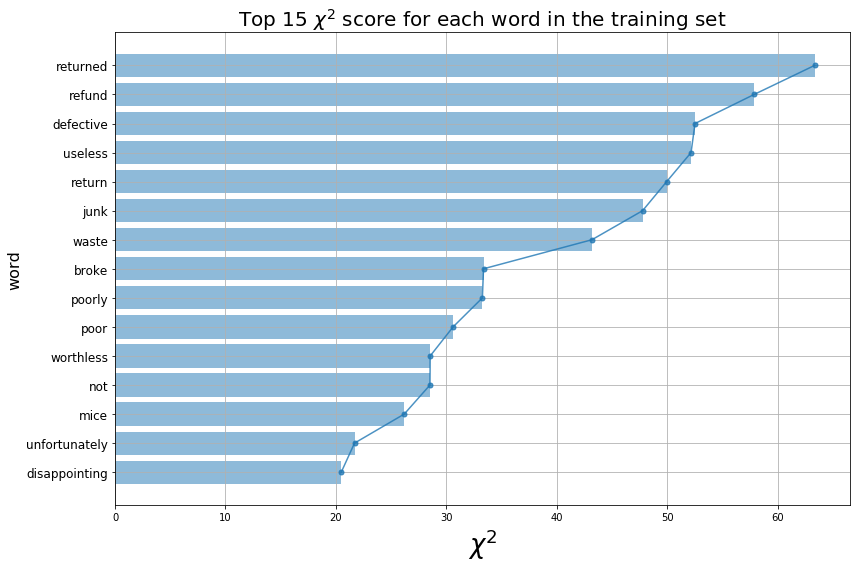

In [138]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

In [139]:
from collections import Counter
Counter(y_train)

Counter({'pos': 28151, 'neg': 1849})

¿Porque son todas negativas?. Vemos que hay muchas más opiniones negativas que positivas.
Los  adjetivos negativos suelen expresarse siempre con la misma palabra, por lo que van a tener una mayor presencia que los positivos.

In [140]:
prueba= df

In [141]:
prueba.head()

,review,sentiment,sentiment_label
41189,Besides the benefit of having twice the erasin...,5,pos
44500,"These pens are great. Smooth writing, and I r...",5,pos
37849,"I've had Epson and HP printers, and both have ...",5,pos
12647,love this mount. works great and looks good to...,5,pos
9831,It is okay. It serves the purpose. It is a goo...,3,pos


In [142]:
import sys
sys.path.append('../..')


from utils import load_cinema_reviews, get_lemmas_dict

In [143]:
data_path = '../../data'
lemmas_dict_file = 'lemmatization-en.txt'
lemmas_dict = get_lemmas_dict(data_path, lemmas_dict_file)

In [144]:
limpio = []
for text in prueba['review']:
    limpio.append(text_normalizer(text, lemmatize=True))

In [145]:
type(limpio)

list

In [146]:
df3 = pd.DataFrame(limpio)

In [164]:
df3.columns = ['reviewLemm']

In [165]:
df3.head()

,reviewLemm
0,besides the benefit of have twice the erase po...
1,this pen be great smooth write and i really li...
2,ive have epson and hp printer and both have th...
3,love this mount work great and look good too a...
4,it be okay it serve the purpose it be a good f...


In [186]:

prueba["reviewLemm"] = np.nan

In [187]:
prueba.head()

,review,sentiment,sentiment_label,reviewLemm
41189,Besides the benefit of having twice the erasin...,5,pos,NaN
44500,"These pens are great. Smooth writing, and I r...",5,pos,NaN
37849,"I've had Epson and HP printers, and both have ...",5,pos,NaN
12647,love this mount. works great and looks good to...,5,pos,NaN
9831,It is okay. It serves the purpose. It is a goo...,3,pos,NaN


In [188]:
prueba['reviewLemm'] = df3['reviewLemm'].values

In [189]:
prueba.head()

,review,sentiment,sentiment_label,reviewLemm
41189,Besides the benefit of having twice the erasin...,5,pos,besides the benefit of have twice the erase po...
44500,"These pens are great. Smooth writing, and I r...",5,pos,this pen be great smooth write and i really li...
37849,"I've had Epson and HP printers, and both have ...",5,pos,ive have epson and hp printer and both have th...
12647,love this mount. works great and looks good to...,5,pos,love this mount work great and look good too a...
9831,It is okay. It serves the purpose. It is a goo...,3,pos,it be okay it serve the purpose it be a good f...


In [190]:
prueba.drop(['review'], axis=1)

,sentiment,sentiment_label,reviewLemm
41189,5,pos,besides the benefit of have twice the erase po...
44500,5,pos,this pen be great smooth write and i really li...
37849,5,pos,ive have epson and hp printer and both have th...
12647,5,pos,love this mount work great and look good too a...
9831,3,pos,it be okay it serve the purpose it be a good f...
...,...,...,...
10903,5,pos,it work and it fit perfect it fit tight and wo...
1587,4,pos,if you be replace your old butterfly tree you ...
3465,4,pos,﻿1 of all there be no artificial bird a pictur...
17498,5,pos,if this will fit in your interior light fixtur...


In [194]:
X_train, X_test, y_train, y_test = train_test_split(
    prueba['reviewLemm'],
    prueba['sentiment_label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

In [195]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=0.05,
    max_features=5000,
    strip_accents='ascii',
    ngram_range=(1, 1)
)
cv.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=5000,
                min_df=0.05, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='ascii',
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [196]:
print(list(cv.vocabulary_.items())[:20])

[('its', 91), ('one', 127), ('great', 68), ('like', 101), ('the', 188), ('that', 186), ('old', 124), ('sound', 175), ('and', 9), ('on', 125), ('be', 17), ('use', 210), ('this', 196), ('with', 224), ('give', 65), ('you', 229), ('really', 153), ('clean', 33), ('if', 82), ('conjurer', 36)]


In [197]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

In [198]:
doc_vector = X_train_[i]
df_tfidf = pd.DataFrame(doc_vector.T.todense(), index=cv.get_feature_names(), columns=['tfidf'])
df_tfidf = df_tfidf[df_tfidf['tfidf'] > 0]

top_n = 10
print('Top {} words with highest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[:top_n]))
print('\nTop {} words with lowest TF_IDF in the review {}:\n{}'.format(top_n, i, df_tfidf.sort_values(by=["tfidf"],ascending=False)[-top_n:]))

Top 10 words with highest TF_IDF in the review 15:
            tfidf
do       0.355251
what     0.347941
product  0.327767
to       0.301602
up       0.287968
its      0.281838
remove   0.242301
sure     0.211590
put      0.196359
im       0.189112

Top 10 words with lowest TF_IDF in the review 15:
         tfidf
need  0.158111
this  0.149404
will  0.144216
and   0.143706
they  0.136618
so    0.122521
use   0.104289
on    0.103829
for   0.090187
be    0.071527


<>:15: DeprecationWarning: invalid escape sequence \c
<>:17: DeprecationWarning: invalid escape sequence \c
<>:15: DeprecationWarning: invalid escape sequence \c
<>:17: DeprecationWarning: invalid escape sequence \c
<>:15: DeprecationWarning: invalid escape sequence \c
<>:17: DeprecationWarning: invalid escape sequence \c
<ipython-input-199-b0b06cd722ad>:15: DeprecationWarning: invalid escape sequence \c
  plt.xlabel('$\chi^2$', fontsize=26)
<ipython-input-199-b0b06cd722ad>:17: DeprecationWarning: invalid escape sequence \c
  plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)


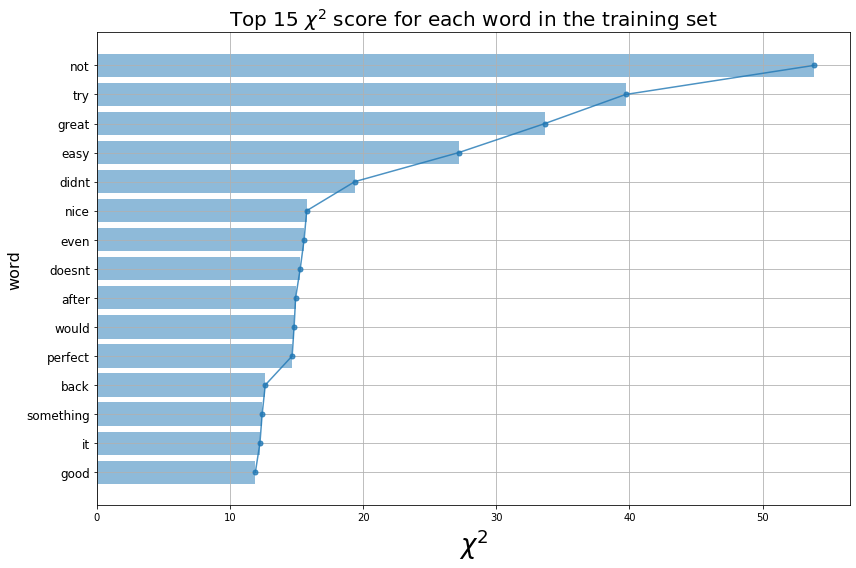

In [199]:
# Compute the chi-squared score for each word in the training set and show the values
i = 15

chi2score = chi2(X_train_, y_train)[0]
scores = list(zip(cv.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

In [200]:
c_params = [0.01, 0.05, 0.25, 0.5, 1, 10, 100, 1000, 10000]

train_acc = list()
test_acc = list()
for c in c_params:
    lr = LogisticRegression(C=c, solver='lbfgs', max_iter=500)
    lr.fit(X_train_, y_train)
    
    train_predict = lr.predict(X_train_)
    test_predict = lr.predict(X_test_)
    
    print ("Accuracy for C={}: {}".format(c, accuracy_score(y_test, test_predict)))
    
    train_acc.append(accuracy_score(y_train, train_predict))
    test_acc.append(accuracy_score(y_test, test_predict))

Accuracy for C=0.01: 0.9396
Accuracy for C=0.05: 0.9396
Accuracy for C=0.25: 0.9396
Accuracy for C=0.5: 0.94
Accuracy for C=1: 0.9406
Accuracy for C=10: 0.9395
Accuracy for C=100: 0.9396
Accuracy for C=1000: 0.9396
Accuracy for C=10000: 0.9395


Nos esta dando unos accuracis bastante altos, eso significa que hay over fitting. Deberiamos cambiar los parametros del modelo, tambien podriamos analizar en base a bigramas o trigramas o realizar un mejor preprocesado.

# Generación de Lenguaje natural

In [201]:
df = pd.read_csv('../../data/BarackObama.csv')

In [202]:
df.head()

,Unnamed: 0,date,id,link,retweet,text,author
0,0,20h20 hours ago,786982739517943808,/BarackObama/status/786982739517943808,False,Denying climate change is dangerous. Join @OFA...,BarackObama
1,1,18h18 hours ago,787010142378332160,/BarackObama/status/787010142378332160,False,The American Bar Association gave Judge Garlan...,BarackObama
2,2,16h16 hours ago,787039774330748928,/BarackObama/status/787039774330748928,False,We need a fully functional Supreme Court. Edit...,BarackObama
3,3,21h21 hours ago,786964419905523712,/BarackObama/status/786964419905523712,False,"Cynics, take note: When we #ActOnClimate, we b...",BarackObama
4,4,Oct 13,786680553617629184,/BarackObama/status/786680553617629185,False,"""That’s how we will overcome the challenges we...",BarackObama


In [203]:
df.dropna(subset=['text'], inplace=True)

In [204]:
text = ''
for t in df['text']:
    text += ' ' + t

In [207]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.utils import np_utils

## Preprocessing

In [208]:
characters = sorted(list(set(text)))
n_to_char = {n:char for n, char in enumerate(characters)}
char_to_n = {char:n for n, char in enumerate(characters)}

In [209]:
X = []
Y = []
length = len(text)
seq_length = 100
for i in range(0, length-seq_length, 1):
    sequence = text[i:i + seq_length]
    label =text[i + seq_length]
    X.append([char_to_n[char] for char in sequence])
    Y.append(char_to_n[label])
X_modified = np.reshape(X, (len(X), seq_length, 1))
X_modified = X_modified / float(len(characters))
Y_modified = np_utils.to_categorical(Y)
vocab_size = len(characters)


In [210]:
vocab_size

102

In [211]:
model_1_path = '../../data/practica/model_1.h5'
model_2_path = '../../data/practica/model_2.h5'


In [ ]:
# Model 1
model_1 = Sequential()
model_1.add(LSTM(400, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
model_1.add(Dropout(0.2))
model_1.add(LSTM(400))
model_1.add(Dropout(0.2))
model_1.add(Dense(Y_modified.shape[1], activation='softmax'))
model_1.compile(loss='categorical_crossentropy', optimizer='adam')
model_1.summary()

history = model_1.fit(X_modified, Y_modified, validation_split=0.05, batch_size=128, epochs=10, shuffle=True).history

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 100, 400)          643200    
_________________________________________________________________
dropout_8 (Dropout)          (None, 100, 400)          0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 400)               1281600   
_________________________________________________________________
dropout_9 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 102)               40902     
Total params: 1,965,702
Trainable params: 1,965,702
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3346/5859 [================>.............] - ETA: 1:59:53 - loss: 2.8619

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history = model_1.fit(X_modified, Y_modified, validation_split=0.05, batch_size=128, epochs=10, shuffle=True).history

In [216]:
# Model 2
model_2 = Sequential()
model_2.add(LSTM(700, input_shape=(X_modified.shape[1], X_modified.shape[2]), return_sequences=True))
model_2.add(Dropout(0.2))
model_2.add(LSTM(700))
model_2.add(Dropout(0.2))
model_2.add(Dense(Y_modified.shape[1], activation='softmax'))
model_2.compile(loss='categorical_crossentropy', optimizer='adam')
model_2.summary()

history = model_2.fit(X_modified, Y_modified, validation_split=0.05, batch_size=128, epochs=10, shuffle=True).history

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 100, 700)          1965600   
_________________________________________________________________
dropout_6 (Dropout)          (None, 100, 700)          0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 700)               3922800   
_________________________________________________________________
dropout_7 (Dropout)          (None, 700)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 102)               71502     
Total params: 5,959,902
Trainable params: 5,959,902
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
history = model_2.fit(X_modified, Y_modified, validation_split=0.05, batch_size=128, epochs=10, shuffle=True).history

In [ ]:
def generate_text(model, string_id):
    string_mapped = deepcopy(string_id)
    full_string = [n_to_char[value] for value in string_mapped]
    
    # Generating characters
    for i in range(400):
        x = np.reshape(string_mapped,(1,len(string_mapped), 1))
        x = x / float(len(characters))

        pred_index = np.argmax(model.predict(x, verbose=0))
        seq = [n_to_char[value] for value in string_mapped]
        full_string.append(n_to_char[pred_index])

        string_mapped.append(pred_index)
        string_mapped = string_mapped[1:len(string_mapped)]
        
    text = ""
    for char in full_string:
        text = text + char
    return text

In [ ]:
model_1_results = generate_text(model_1, X[5])

In [ ]:
model_2_results = generate_text(model_2, X[5])

In [ ]:
t = ''
for ch in X[5]:
    t += n_to_char.get(ch)
print(t)

In [ ]:
print(model_1_results)

In [ ]:
print(model_2_results)

Buenas Carlos, intente implemenar el modelo de NLG pero el ordenador me petada, intente incluso rebajar el dataset y nada, no entiendo porque, cuando llegaba a cierta epoca me petaba.
Y como, se me echo el tiempo encima, no te pude preguntar que hacer, disculpa esta parte de la practica, la verdad es que estoy bastante contento con ella salvo esta ultima parte.